In [13]:
import tornado
tornado.version

'6.1'

In [4]:
# import pymatgen
import freud
import aiida
import ase
from aiida import orm, load_profile 
import matplotlib.pyplot as plt
from aiida.orm import QueryBuilder
from collections import Counter
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import ase
from math import pi
import numpy as np
from ase.atoms import Atoms
from ase.calculators import calculator
from ase.calculators.calculator import Calculator, kpts2ndarray
from ase import Atoms
from operator import itemgetter 
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing 
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from mpl_toolkits.mplot3d import Axes3D
import random
from aiida.orm import ArrayData
from aiida.orm import TrajectoryData
from aiida.orm import StructureData
from ase import Atoms
import matplotlib
from matplotlib import cm
from matplotlib.colors import Colormap as cmap
import freud
import matplotlib.cm
import numpy as np
import rowan
import plato.draw.fresnel
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull, convex_hull_plot_2d

ModuleNotFoundError: No module named 'tornado.stack_context'

In [12]:
def plot_crystal(box, positions, colors=None, radii=None, backend=None,
                 polytopes=[], polytope_colors=None):
    if backend is None:
        backend = plato.draw.fresnel
    if colors is None:
        colors = np.array([[0.5, 0.5, 0.5, 1]] * len(positions))
    if radii is None:
        radii = np.array([0.5] * len(positions))
    sphere_prim = backend.Spheres(positions=positions, colors=colors, radii=radii)
    box_prim = backend.Box.from_box(box, width=0.1)
    if polytope_colors is None:
        polytope_colors = colors * np.array([1, 1, 1, 0.4])
    polytope_prims = []
    for p, c in zip(polytopes, polytope_colors):
        p_prim = backend.ConvexPolyhedra(
            positions=[[0, 0, 0]], colors=c, vertices=p, outline=0)
        polytope_prims.append(p_prim)
    rotation = rowan.multiply(
        rowan.from_axis_angle([1, 0, 0], np.pi/10),
        rowan.from_axis_angle([0, 1, 0], -np.pi/10))
    scene = backend.Scene([sphere_prim, box_prim, *polytope_prims],
                          zoom=3, rotation=rotation)
    if backend is not plato.draw.fresnel:
        scene.enable('directional_light')
    else:
        scene.enable('antialiasing')
    scene.show()
def make_cubic_grid(box, voxels_per_side):
    v_space = np.linspace(0, 1, voxels_per_side+1)
    v_space = (v_space[:-1] + v_space[1:])/2  # gets centers of the voxels
    return np.array([box.make_absolute([x, y, z])
                     for x in v_space for y in v_space for z in v_space])
def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
#         if -1 in indices: # some regions can be opened
#             vol[i] = np.inf
#         else:
        vol[i] = ConvexHull(v.vertices[indices]).volume
    return vol

[[11.4597    2.8425    7.55503 ]
 [ 5.0397    2.8425   11.86997 ]
 [ 1.3803    0.9475    5.39497 ]
 [ 7.8003    0.9475    1.08003 ]
 [10.966644  2.8425    2.6159  ]
 [ 4.546644  2.8425    3.8591  ]
 [ 1.873356  0.9475   10.3341  ]
 [ 8.293356  0.9475    9.0909  ]
 [ 8.11488   2.8425    5.38461 ]
 [ 1.69488   2.8425    1.09039 ]
 [ 4.72512   0.9475    7.56539 ]
 [11.14512   0.9475   11.85961 ]
 [12.40344   2.8425    4.93395 ]
 [ 5.98344   2.8425    1.54105 ]
 [ 0.43656   0.9475    8.01605 ]
 [ 6.85656   0.9475   11.40895 ]
 [10.04088   2.8425    9.8679  ]
 [ 3.62088   2.8425    9.5571  ]
 [ 2.79912   0.9475    3.0821  ]
 [ 9.21912   0.9475    3.3929  ]
 [ 9.55296   2.8425    0.3367  ]
 [ 3.13296   2.8425    6.1383  ]
 [ 3.28704   0.9475   12.6133  ]
 [ 9.70704   0.9475    6.8117  ]
 [ 6.79236   2.8425    8.01605 ]
 [ 0.37236   2.8425   11.40895 ]
 [ 6.04764   0.9475    4.93395 ]
 [12.46764   0.9475    1.54105 ]]


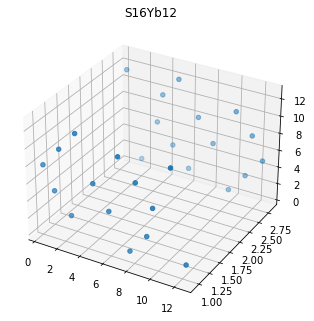

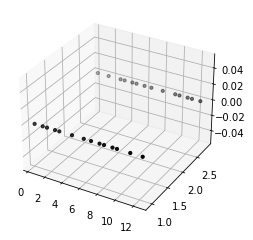

Text(0.5, 1.0, 'Voronoi cell volumes')

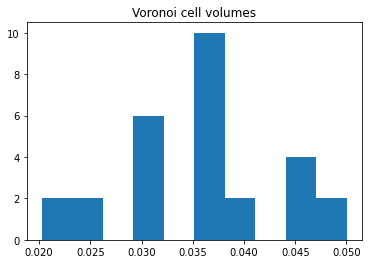

In [35]:
backend = plato.draw.fresnel
cmap = matplotlib.cm.get_cmap('tab20')
group = load_group('structures/unique')
structure = group.nodes[1]
# print(structure.extras)
ase_atoms = structure.get_ase()
xyz=ase_atoms.get_positions()
print(xyz)

colors = cmap(np.random.rand(len(xyz)))
fig = plt.figure()
ax = Axes3D(fig)
plt.title(str(structure.extras['formula_hill']))
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:,2])
plt.show()
# print(np.amax(xyz))
L = 1
box = freud.box.Box.cube(L)
voro = freud.locality.Voronoi()
cells = voro.compute((box, xyz)).polytopes
plt.show()
plt.figure()
ax=plt.gca(projection='3d')
voro.plot(ax=ax, cmap='RdBu')
ax.scatter3D(xyz[:, 0], xyz[:, 1], s=10, c='k')
plt.show()
# print(sum(voro.volumes))
# print(voro.positions)
plt.hist(voro.volumes)
plt.title('Voronoi cell volumes')
# plt.show()

# nlist = voro.nlist
# line_data = np.asarray([[xyz[i],
#                          xyz[i] + box.wrap(xyz[j] - xyz[i])]
#                         for i, j in nlist])[:, :, :2]
# line_collection = matplotlib.collections.LineCollection(line_data, alpha=0.2)
# plt.figure()
# ax = plt.gca()
# voro.plot(ax=ax, cmap='RdBu')
# ax.add_collection(line_collection)
# plt.show()


In [86]:
group = load_group('structures/unique')
print((group))
structure = group.nodes[:]
vol=[]
natoms=[]

"structures/unique" [type core], of user elena.gazzarrini@epfl.ch


In [95]:

# print(structure.extras)
# print(group.nodes)
# l=len(structure[:])
# print(l)
# len(structure[9].sites)
print(type(structure))
for i in structure:
    natom=len(structure[i].sites)
    natoms.append(natom)
    structure = group.nodes[i]
    ase_atoms = structure.get_ase()
    print(ase_atoms)
    xyz=ase_atoms.get_positions()
    print(xyz)
    v=sum(voronoi_volumes(xyz))
    print(v)
    vol.append(v)
print(len(vol), len(natoms))
plt.plot(natoms, vol)

<class 'aiida.orm.nodes.data.structure.StructureData'>


TypeError: 'StructureData' object is not iterable

In [41]:
skip=1000  #usually complete it is 79855
load_profile()
qb = QueryBuilder()
qb.append(orm.StructureData)
qb.count()
qb_red=qb.all()[::skip]
group = ('structures/unique')


{'source': {'id': 'S310755', 'version': '1.0.0', 'database': 'mpds'}, 'duplicates': {'cod': ['effa769e-bf33-44e1-b7ce-ef30ebe9c184'], 'mpds': ['000112f5-6755-4160-a95a-5d3a4140cd18']}, 'formula_hill': 'S16Yb12', 'bravais_lattice': 'oP', 'chemical_system': '-S-Yb-', 'spacegroup_number': 62, 'partial_occupancies': False, 'formula_hill_compact': 'S4Yb3', 'bravais_lattice_extended': 'oP1', 'spacegroup_international': 'Pnma'}


AttributeError: 'str' object has no attribute 'nodes'

In [102]:
vol=[]
natoms=[]
for [structure_data] in qb_red:
    print(structure_data)
    natom=len(structure_data.sites)
#     natoms.append(len(structure_data.get_site_kindnames()))
#     print(natom)
    natoms.append(natom)
    ase_atoms = structure_data.get_ase()
    print(ase_atoms)
    xyz=ase_atoms.get_positions()
    print(xyz)
    v=sum(voronoi_volumes(xyz))
    print(v)
    vol.append(v)
    
print(vol)
pl.plot()


uuid: 0000ae1c-7966-4c2f-9061-b1aa0ef616d5 (pk: 1)
Atoms(symbols='Re4H8N4O8', pbc=True, cell=[[-2.9978, 2.9978, 6.23915], [2.9978, -2.9978, 6.23915], [2.9978, 2.9978, -6.23915]], masses=...)
[[-4.44089210e-16  4.49670000e+00  1.55978750e+00]
 [ 0.00000000e+00  1.49890000e+00  1.55978750e+00]
 [ 1.49890000e+00  2.99780000e+00  4.67936250e+00]
 [ 4.49670000e+00  2.99780000e+00  4.67936250e+00]
 [ 2.20038520e+00  1.75311344e+00  9.68316080e-01]
 [ 2.20038520e+00  4.75091344e+00  2.15125892e+00]
 [ 4.75091344e+00  7.97414800e-01  5.27083392e+00]
 [ 1.75311344e+00  7.97414800e-01  4.08789108e+00]
 [ 3.79521480e+00  4.24248656e+00  9.68316080e-01]
 [ 3.79521480e+00  1.24468656e+00  2.15125892e+00]
 [ 1.24468656e+00  5.19818520e+00  5.27083392e+00]
 [ 4.24248656e+00  5.19818520e+00  4.08789108e+00]
 [ 2.99780000e+00  1.49890000e+00  1.55978750e+00]
 [ 2.99780000e+00  4.49670000e+00  1.55978750e+00]
 [ 4.49670000e+00  0.00000000e+00  4.67936250e+00]
 [ 1.49890000e+00  0.00000000e+00  4.6793625

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull v Qc Qz Qbb
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2110672936  voronoi  Qcoplanar-keep  Qz-infinity-point  Qbbound-last
  _pre-merge  _zero-centrum  Qinterior-keep  Pgood  _max-width 4.7
  Error-roundoff 9.4e-15  _one-merge 8.5e-14  Visible-distance 5.7e-14
  U-max-coplanar 5.7e-14  Width-outside 1.1e-13  _wide-facet 3.4e-13
  _maxoutside 1.1e-13

precision problems (corrected unless 'Q0' or an error)
      2 zero divisors during gaussian elimination

The input to qhull appears to be less than 4 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p3(v5):   2.1   2.1   4.7   4.3
- p4(v4): 2.8e-18 -2.8e-18   1.8  0.47
- p1(v3): 5.1e-17 -5.1e-17   4.5   2.8
- p0(v2):   2.1   2.1     2   1.8
- p2(v1):     0     0     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 9.4e-15.  The center point, facets and distances
to the center point are as follows:

center point   0.8304   0.8304    2.611    1.865

facet p4 p1 p0 p2 distance= 5e-17
facet p3 p1 p0 p2 distance=    0
facet p3 p4 p0 p2 distance=    0
facet p3 p4 p1 p2 distance= -3.7e-16
facet p3 p4 p1 p0 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:         0     2.076  difference= 2.076
  1:  -5.064e-17     2.076  difference= 2.076
  2:         0     4.685  difference= 4.685
  3:         0     4.685  difference= 4.685

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 9.4e-15.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


[1161.3970322424755, 2208299.919776427, 636071.8524750982, 6690.030574814915] [24, 64, 60, 10]


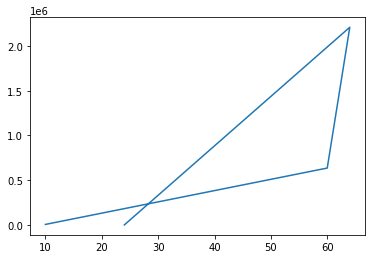

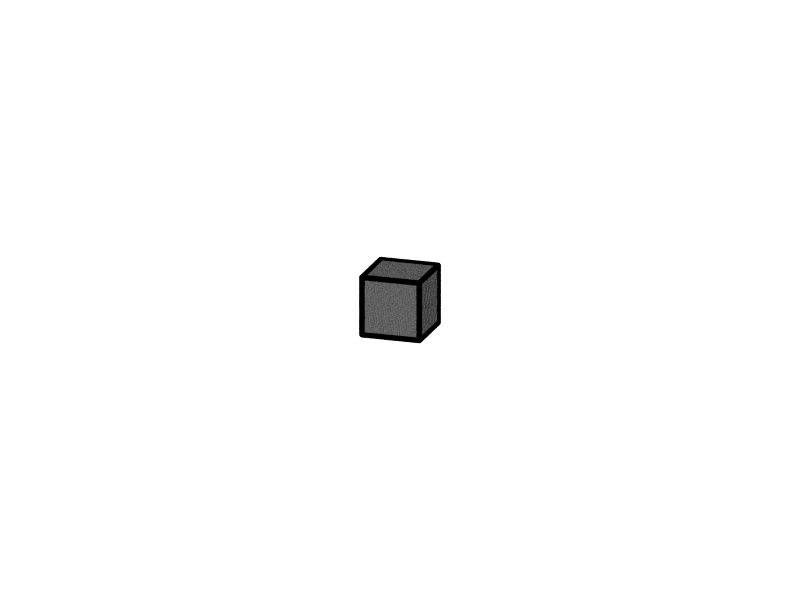

/home/egazzarrini/anaconda3/envs/aiida/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


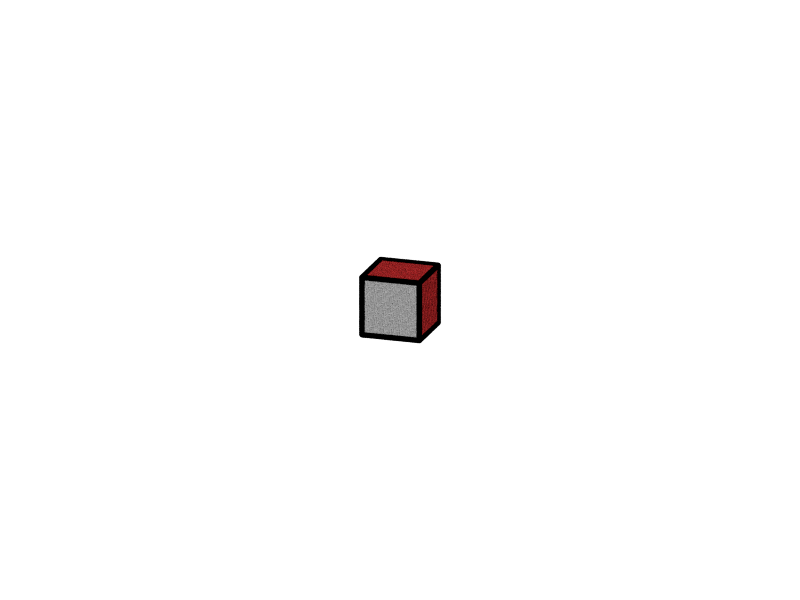

In [110]:
# voxelization
print(vol, natoms[:4])
plt.plot(natoms[:4], vol)

plt.show()
voxels_per_side = 50
cubic_grid = make_cubic_grid(box, voxels_per_side)

# Make the spheres overlap just a bit
radii = np.ones(len(cubic_grid)) * 0.8 * np.max(box.L) / voxels_per_side

plot_crystal(box, cubic_grid, radii=radii, backend=backend)

aq = freud.AABBQuery(box, xyz)
voxel_neighbors = -np.ones(len(cubic_grid), dtype=np.int)
for i, j, distance in aq.query(cubic_grid, {'num_neighbors': 1}):
    voxel_neighbors[i] = j
voxel_colors = np.array([colors[i] for i in voxel_neighbors])
plot_crystal(box, cubic_grid, colors=voxel_colors,
             radii=radii, backend=backend)

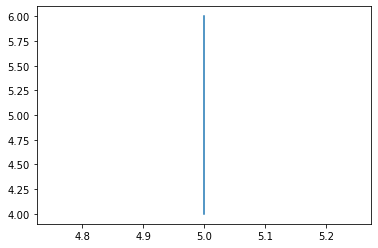

In [18]:
#dataset load 
skip=100  #usually complete it is 79855
# load_profile()
qb = QueryBuilder()
qb.append(orm.StructureData)
qb.count()
qb_red=qb.all()[::skip] #reduced dataset 

NameError: name 'QueryBuilder' is not defined